In [1]:
import pandas as pd
import numpy as np
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, BatchSampler
import torchvision as tv
import torchmetrics
import pytorch_lightning as pl
from torchvision import transforms

import wandb
from pytorch_lightning.loggers import WandbLogger

In [2]:
class CharacterDataset(Dataset):
    def __init__(self, X, Y, transforms=None):
        self.X = X
        self.Y = Y
        
        self.transforms = transforms
    
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        '''Input image is scaled b/w 0,1'''
        x= self.X[idx]
        y= self.Y[idx]
        
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.long)
        # adds a new axis at specified position
        x = torch.unsqueeze(x, dim=1)
        if self.transforms is not None:
            x = self.transforms(x)
        return x/255., y


class SimpleBatchDataLoader:
    def __init__(self, dataset, shuffle=True, drop_last=False, batch_size=32):
        self.dataset = dataset
        if shuffle:
            self.sampler = RandomSampler(dataset)
        else:
            self.sampler = SequentialSampler(dataset)
        
        self.batch_sampler = BatchSampler(self.sampler, drop_last=drop_last, batch_size=batch_size)
        
    def __len__(self):
        return len(self.batch_sampler)
    
    def __iter__(self):
        for batch_idx in self.batch_sampler:
            yield self.dataset[batch_idx]

In [3]:
# add self.transforms for train time augmentations


class DataModuleForCharacterClassification(pl.LightningDataModule):

    def __init__(self, args, use_transforms=None):
        super().__init__()
        self.hparams = args
        if use_transforms is not None:
            self.transforms = transforms.Compose([
                transforms.RandomRotation(10),
                transforms.RandomAffine(10, shear=5),
            ])
        else:
            self.transforms = None
        
    def prepare_data(self):
        df = pd.read_csv('../input/devanagari-character-set/data.csv')
        
        ch_set = df.character.unique()
        ch_set = [name for name in ch_set if name.startswith('character_')]
        
        ch2id = {name:int(name.split('_')[1]) for name in ch_set}
        id2ch = {int(name.split('_')[1]) : name.split('_')[-1] for name in ch_set}
        
        id2devchar = {
             1: 'क', 2: 'ख', 3: 'ग', 4: 'घ', 5: 'ङ', 6: 'च', 7: 'छ', 8: 'ज', 9: 'झ', 10: 'ञ',
             11: 'ट', 12: 'ठ', 13: 'ड', 14: 'ढ', 15: 'ण', 16: 'त', 17: 'थ', 18: 'द', 19: 'ध',
             20: 'न', 21: 'प', 22: 'फ', 23: 'ब', 24: 'भ', 25: 'म', 26: 'य', 27: 'र', 28: 'ल', 
             29: 'व', 30: 'श', 31: 'ष', 32: 'स', 33: 'ह', 34: 'क्ष', 35: 'त्र', 36: 'ज्ञ', 37: 'अ', 
             38: 'आ', 39: 'इ', 40: 'ई', 41: 'उ', 42: 'ऊ', 43: 'ऋ', 44: 'ए', 45: 'ऐ', 46: 'ओ', 
             47: 'औ', 48: 'अं', 49: 'अ:'
        }
        devchar2id = {v:k for k,v in id2devchar.items()}
        
        ch_used = self.hparams.class_names
        id_used = [devchar2id[x] for x in ch_used]
        
        id2labels_map = {id_:i for i, id_ in enumerate(id_used)}
        labels2id_map = {v:k for k,v in id2labels_map.items()}
        
        df = df.loc[df.character.str.startswith('character_'), :]
        df.character = df.character.apply(lambda x:ch2id[x])
        df = df.loc[df.character.isin(id_used),:]
        df.character = df.character.apply(lambda x:id2labels_map[x])
        
        X = df.iloc[:, :-1].values.reshape(-1, 32, 32)
        Y = df.iloc[:, -1].values
        
        from sklearn.model_selection import train_test_split
        self.train_X, self.val_X, self.train_Y, self.val_Y = train_test_split(
            X, Y, test_size=0.2, shuffle=True, random_state=420, stratify=Y
        )
        
        self.ch_used = ch_used
        self.labels2id_map = labels2id_map
        
        labels2devchar = {k:id2devchar[v] for k,v in labels2id_map.items()}
        devchar2labels = {v:k for k,v in labels2devchar.items()}
        
        self.labels2devchar = labels2devchar
        self.devchar2labels = devchar2labels
        
        del df
        
    def train_dataloader(self):
        ds = CharacterDataset(self.train_X, self.train_Y, transforms=self.transforms)
        return SimpleBatchDataLoader(ds, shuffle=True, drop_last=True, batch_size=self.hparams.batch_size)
    
    def val_dataloader(self):
        ds = CharacterDataset(self.val_X, self.val_Y, transforms=None)
        return SimpleBatchDataLoader(ds, shuffle=False, drop_last=True, batch_size=self.hparams.batch_size)

In [4]:
class HindiCharNet(nn.Module):
    '''
    For using forward/__call__ function:
    Input: Tensor of shape (Batch, 1, 32, 32) ie (Batch, Channels, X, Y) 
    Output: logits as a Tensor of shape (Batch, NUM_CLASSES)
    '''
    def __init__(self, NUM_CLASSES, NUM_CHANNELS=1):
        super(HindiCharNet, self).__init__()
        
        self.conv1 = nn.Conv2d(NUM_CHANNELS, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, NUM_CLASSES)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        # x.shape = (BATCH, 250, 3, 3)
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [5]:
class LightningModuleForCharacterClassification(pl.LightningModule):
    '''
    pytorch lightning trainer class
    '''
    
    def __init__(self, args, model, **kwargs):
        super().__init__()

        self.save_hyperparameters(args)
        self.model = model
        
        self.accuracy = torchmetrics.Accuracy()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=self.hparams.num_classes)
        
        self.outputs = {}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = F.cross_entropy(y_pred, y)
        class_probs = y_pred.softmax(-1)
        self.log("train_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", self.accuracy(class_probs, y), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = F.cross_entropy(y_pred, y)
        class_probs = y_pred.softmax(-1)
        self.log("valid_loss", loss.item(), on_step=False, on_epoch=True, prog_bar=False, logger=True)
        self.log("valid_acc", self.accuracy(class_probs, y), on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return {'class_probs':class_probs, 'y_true':y}
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        loss = F.cross_entropy(y_pred, y)
        class_probs = y_pred.softmax(-1)
        return {'class_probs':class_probs, 'y_true':y}
    
    def validation_epoch_end(self, outputs):
        class_probs = torch.cat([out["class_probs"] for out in outputs])
        y_true = torch.cat([out["y_true"] for out in outputs])
        c_mat = self.confusion_matrix(class_probs, y_true)
        
        self.outputs[f"val_c_mat_epoch{self.current_epoch}"] = c_mat
        
        self.logger.experiment.log({
            'val_conf_mat': wandb.plot.confusion_matrix(
                y_true=y_true.to("cpu").detach().numpy(), 
                probs=class_probs.to("cpu").detach().numpy(), 
                class_names=self.hparams.class_names)
        })
        
        if self.current_epoch>4:
            temp_model = self.model
            temp_model.cpu()
            torch.save(temp_model.state_dict(), f'hindi-char-net-26chars-v8-epoch{self.current_epoch}.pt')
            temp_model.cuda()
            
    def test_epoch_end(self, outputs):
        class_probs = torch.cat([out["class_probs"] for out in outputs])
        y_true = torch.cat([out["y_true"] for out in outputs])
        c_mat = self.confusion_matrix(class_probs, y_true)
        self.outputs["test_c_mat"] = c_mat
        
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.hparams.base_lr)

In [6]:
def get_char_set(num):
    all_chars = {1: 'क', 2: 'ख', 3: 'ग', 4: 'घ', 5: 'ङ', 6: 'च', 7: 'छ', 8: 'ज', 9: 'झ', 10: 'ञ', 11: 'ट', 12: 'ठ', 13: 'ड', 14: 'ढ', 15: 'ण', 16: 'त', 17: 'थ', 18: 'द', 19: 'ध', 20: 'न', 21: 'प', 22: 'फ', 23: 'ब', 24: 'भ', 25: 'म', 26: 'य', 27: 'र', 28: 'ल', 29: 'व', 30: 'श', 31: 'ष', 32: 'स', 33: 'ह', 34: 'क्ष', 35: 'त्र', 36: 'ज्ञ', 37: 'अ', 38: 'आ', 39: 'इ', 40: 'ई', 41: 'उ', 42: 'ऊ', 43: 'ऋ', 44: 'ए', 45: 'ऐ', 46: 'ओ', 47: 'औ', 48: 'अं', 49: 'अ:'}

    if num == 49:
        ch_used = list(all_chars.values())
    else:
        import random
        ch_used = random.sample(list(all_chars.values())[:36], num)
    return ch_used

print(get_char_set(49)[:36])

['क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'क्ष', 'त्र', 'ज्ञ']


In [7]:
all_chars = ['क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'क्ष', 'त्र', 'ज्ञ']

used =   [
    'क', 'ख', 'घ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ',
    'त','थ','द', 'न','प', 'फ', 'म', 'र', 'ल', 'व', 'स', 'ह', 'क्ष', 'त्र', 
]

removed = ['ग','ङ', 'ध', 'ब', 'भ', 'य', 'श','ष','ण','ज्ञ']

In [8]:
set(used).intersection(set(removed))
len(set(used).union(set(removed)))
len(used)

26

In [9]:
import argparse
args = argparse.Namespace()

args.max_epochs = 10
args.gpus = int(torch.cuda.is_available())

args.batch_size = 32
args.base_lr = 0.001

args.class_names =  [
    'क', 'ख', 'घ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ',
    'त','थ','द', 'न','प', 'फ', 'म', 'र', 'ल', 'व', 'स', 'ह', 'क्ष', 'त्र', 
]

args.num_classes = len(args.class_names)

In [10]:
args.num_classes

26

In [11]:
args.logger = WandbLogger( project="mosaic", entity='mosaic2k21')
trainer = pl.Trainer.from_argparse_args(args)


data = DataModuleForCharacterClassification(args)
model = HindiCharNet(args.num_classes)
pl_model = LightningModuleForCharacterClassification(args, model)

In [ ]:
trainer.fit(pl_model, data)

In [13]:
data.labels2devchar

{0: 'क',
 1: 'ख',
 2: 'घ',
 3: 'च',
 4: 'छ',
 5: 'ज',
 6: 'झ',
 7: 'ञ',
 8: 'ट',
 9: 'ठ',
 10: 'ड',
 11: 'ढ',
 12: 'त',
 13: 'थ',
 14: 'द',
 15: 'न',
 16: 'प',
 17: 'फ',
 18: 'म',
 19: 'र',
 20: 'ल',
 21: 'व',
 22: 'स',
 23: 'ह',
 24: 'क्ष',
 25: 'त्र'}

In [14]:
import json

with open("labels2devchar-26chars-v8.json", 'w') as outfile:
    json.dump(data.labels2devchar, outfile)

In [19]:
import glob
save_artifacts_to_wandb = glob.glob("*v8*.pt")
save_artifacts_to_wandb.append("labels2devchar-26chars-v8.json")
save_artifacts_to_wandb

['hindi-char-net-26chars-v8-epoch9.pt', 'labels2devchar-26chars-v8.json']

In [20]:
for artifact in save_artifacts_to_wandb:
    wandb.save(artifact)

In [29]:
# model = pl_model.model.to('cpu')
# torch.save(model.state_dict(), 'hindi-char-net-26chars.pt')
# model.eval()

In [21]:
model = HindiCharNet(26)

model.load_state_dict(torch.load('hindi-char-net-26chars-v8-epoch9.pt'))
model.eval()

HindiCharNet(
  (conv1): Conv2d(1, 100, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(100, 150, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(150, 250, kernel_size=(1, 1), stride=(1, 1))
  (conv3_bn): BatchNorm2d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2250, out_features=350, bias=True)
  (fc1_bn): BatchNorm1d(350, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=350, out_features=26, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
wandb.finish()

In [23]:
cmat9 = pl_model.outputs['val_c_mat_epoch9'].detach().cpu().numpy()

In [17]:
x = cmat9.copy()
diags = []
for i in range(x.shape[0]):
    diags.append(x[i,i])
max(diags), min(diags)

diags = np.asarray(diags)
sorted_labels = np.argsort(diags)
print(np.sort(diags))

[data.labels2devchar[i] for i in sorted_labels[:5]]

print([data.labels2devchar[i] for i in sorted_labels[5:]])

In [24]:
x = cmat9.copy()
min_x = x.min()
for i in range(x.shape[0]):
    x[i,i] = min_x

In [25]:
a, b = np.unique(x, return_counts=True)
a, b

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8., 17.], dtype=float32),
 array([604,  50,   6,   8,   3,   1,   1,   2,   1]))

In [29]:
# for num in a[b==1]:
#     x_, y_ = np.where(x==num)
#     print(data.labels2devchar[x_[0]], data.labels2devchar[y_[0]])

# print('\n\n')
for x_, y_ in zip(np.where(x==17)[0], np.where(x==17)[1]):
    print(data.labels2devchar[x_], data.labels2devchar[y_])
print('\n\n')
for x_, y_ in zip(np.where(x==8)[0], np.where(x==8)[1]):
    print(data.labels2devchar[x_], data.labels2devchar[y_])

द ढ



घ थ
द ट


In [49]:
may_remove = [('ज्ञ', 'ज')]

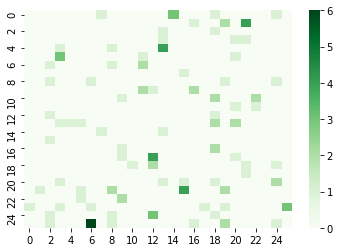

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(x, cmap='Greens');

In [22]:
import os
test_samples = os.listdir('../input/tempdata/')
test_samples = [f'../input/tempdata/{x}' for x in test_samples]

In [23]:
def infer_from_tensors(img_tensor):
    with torch.no_grad():
        logits = model(img_tensor)
    return data.labels2devchar[logits.softmax(-1).argmax(-1)[0].item()]

def infer_from_path(im_path):
    im = cv2.imread(im_path)
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (32,32))
    
    img_tensor = torch.tensor(im, dtype=torch.float)
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0)/255.
#     breakpoint()
    predicted_devchar = infer_from_tensors(img_tensor)
    print(predicted_devchar)
    return predicted_devchar, im

In [24]:
import matplotlib.pyplot as plt

ल


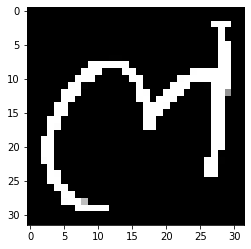

प


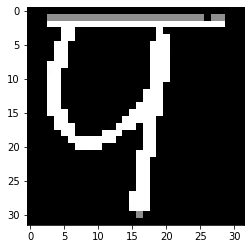

क


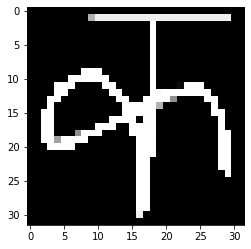

म


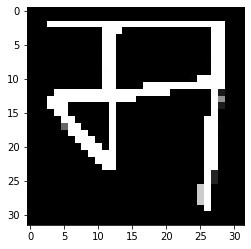

त


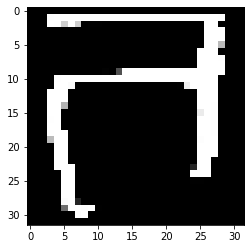

ल


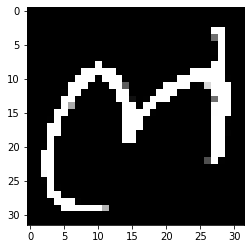

In [27]:
for test_sample in test_samples:
    pred, im = infer_from_path(test_sample)
    plt.imshow(im, cmap='gray')
#     plt.title(pred)
    plt.show()